#### toy grover search
&nbsp; &nbsp; &nbsp; following Nielsen-Chuang ( chapter 6.1 ) and Hidary ( chapter 8.6 )

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ):
    assert n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    b = ( k - len( b ) ) * [ 0 ] + b
    return b # the binary expansion of n, as a list of k bits

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [15]:
def reflection( q ):
    R = [ cirq.Z.controlled( len( q ) - 1 ).on( * q[ : -1 ], q[ -1 ] ) ]
    return R # a gate in a list

In [5]:
def oracle_block( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs # gates in a list

In [19]:
def diffusion_block( q ):
    Hs = [ cirq.H( qn ) for qn in q ]
    Xs = [ cirq.X( qn ) for qn in q ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs # gates in a list

In [21]:
def grover_circuit( q, oracle, width ):
    Hs = [ cirq.H( qn ) for qn in q ]
    blocks = width * ( oracle + diffusion_block( q ) )
    measure = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    circuit = cirq.Circuit( Hs + blocks + measure )
    return circuit

In [22]:
def simulate( q, program, repetitions ):
    result = cirq.Simulator( ).run( program = program, repetitions = repetitions )
    result = [ result.measurements[ str( n ) ] for n in range( len( q ) ) ]
    return np.array( result ).squeeze( )

In [23]:
def plot( measurement, k ):
    count = np.zeros( 2 ** k, dtype = 'float' )
    for n in measurement : count[ n ] += 1
    prob = count / np.sum( count )
    fig, axis = plt.subplots( )
    axis.set_facecolor( 'black' )
    axis.tick_params( colors = 'white' )
    axis.set_xlabel( 'measurement', color = 'white', size = '14' )
    axis.set_ylabel( 'probability', color = 'white', size = '14' )
    axis.plot( range( 2 ** k ), prob, color = 'white', marker = '.', linestyle = 'None' )
    fig.set_figwidth( 11 )
    fig.set_figheight( 6 )
    plt.show( )

In [24]:
def display( circuit, result, width, m ):
    [ k, repetitions ] = result.shape
    w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) 
    measurement = np.array( [ bit2int( result[ : , n ] ) for n in range( repetitions ) ] )
    print( 'grover circuit simulation\n' )
    print( f'qubits        { k }' )
    print( f'optimal width { w } blocks' )
    print( f'actual width  { width } blocks' )
    print( f'looking for   { m } among the numbers { 0 }, { 1 }, ..., { 2 ** k - 1 }\n' )
    if repetitions < 300 : print( f'measurements\n{ measurement }' )
    if k < 20 : plot( measurement, k )
    if width <  3 : print( f'\ncircuit diagram\n{ circuit }' ) 

grover circuit simulation

qubits        5
optimal width 4 blocks
actual width  2 blocks
looking for   6 among the numbers 0, 1, ..., 31

measurements
[ 8  6  1  6 12  6 28 27  6  6 20  4  6 28 19  9  6  6 21  6  6  6 22  6
  9  6  0  6  6  6  6 15  6 12  6  6 26  6  2  6  6  6 22 29  6  6  9 10
  6  9]


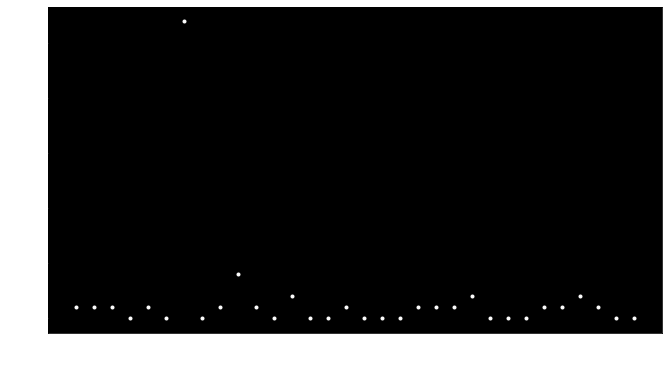


circuit diagram
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('1')───
              │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │
3: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('3')───
              │               │               │               │
4: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('4')───


In [25]:
m = 6 # what we hope to measure
k = 5 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_block( q, m )

w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # optimal width of the circuit, in blocks
w = 2 # try smaller circuit
grover = grover_circuit( q, oracle, w )

repetitions = 50
result = simulate( q, grover, repetitions )
display( grover, result, w, m )

grover circuit simulation

qubits        16
optimal width 200 blocks
actual width  100 blocks
looking for   11111 among the numbers 0, 1, ..., 65535

measurements
[56280 13798 11111 11111 20139 11111 11111 27139 11111 11111 11111 11111
 46057 11111 11111 17585 11111 11727 11111 11111 58172 11111  5046 40321
 11111  8107 52584 59661 11111 11111 11111 59649 11111 25156 57757 22910
 11111 11111 11111 11111 23043 11111 11111 31722 32109 11111   263 11111
 13907 58757]


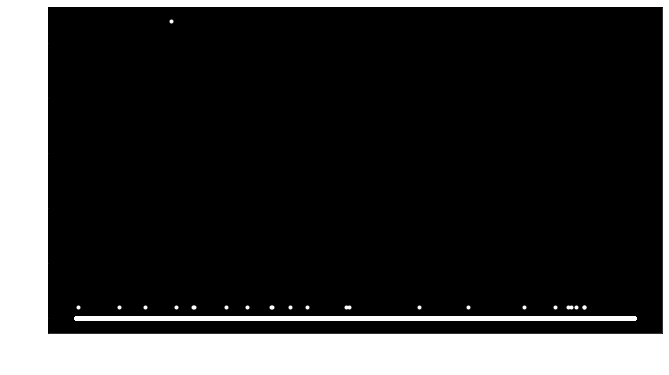

In [26]:
m = 11111 # what we hope to measure
k = 16 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_block( q, m )

w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # optimal width of the circuit, in blocks
w = 100 # try smaller circuit
grover = grover_circuit( q, oracle, w )

repetitions = 50
result = simulate( q, grover, repetitions )
display( grover, result, w, m )